In [90]:
import pandas as pd
import numpy as np
from numpy import int64
import requests
import json
from pathlib import Path
import matplotlib.pyplot as plt
import math
#from pandasql import sqldf

# Cleaning Data to Construct the DataSet Needed for the Visualizing CO2 Emissions Project<br>
-- Import software packages and read in CSVs. Although these data sets are technically available via API call, I emailed with both entities, and they requested since the sets are relatively small that I use CSVs. <br>
-- On the Per Capita CO2 csv I use a list comprehension to rename "Entity" to "Country" at the head of series one, and "Annual CO2 emissions (per capita)" in series 3 for the sake of clarity. I also filter out the country code for now. <br>
-- I repeat the process for the co2 emissions totals as well.

In [2]:
capita = pd.read_csv('/Users/lydia/Projects/PerCapitaCO2Emissions_data_visualization/data/co-emissions-per-capita.csv')

In [3]:
capita.columns=['Country' if x== 'Entity' else 'Per-Capita CO₂ emissions' if x== 'Annual CO₂ emissions' else x for x in capita.columns]  

In [4]:
capita = capita.filter(['Country', 'Year', 'Annual CO₂ emissions (per capita)'], axis=1)

In [5]:
capita.head()

,Country,Year,Annual CO₂ emissions (per capita)
0,Afghanistan,1949,0.001992
1,Afghanistan,1950,0.011266
2,Afghanistan,1951,0.012098
3,Afghanistan,1952,0.011946
4,Afghanistan,1953,0.013685


In [6]:
total_country = pd.read_csv('/Users/lydia/Projects/PerCapitaCO2Emissions_data_visualization/data/annual-co2-emissions-per-country.csv')

In [7]:
total_country.columns=['Country' if x== 'Entity' else x for x in total_country.columns]  

In [8]:
total_country = total_country.filter(['Country', 'Year', 'Annual CO₂ emissions'], axis=1)

In [130]:
total_country.head()

,Country,Year,Annual CO₂ emissions
0,Afghanistan,1949,14656.0
1,Afghanistan,1950,84272.0
2,Afghanistan,1951,91600.0
3,Afghanistan,1952,91600.0
4,Afghanistan,1953,106256.0


-- Next I combine the two sets. The illustrations will be based on the per capita numbers, but I will need the totals for context. 

In [132]:
co2df = pd.merge(capita, total_country, how = 'left', left_on=['Country', 'Year'], right_on = ['Country', 'Year'])

In [11]:
co2df.head()

,Country,Year,Annual CO₂ emissions (per capita),Annual CO₂ emissions
0,Afghanistan,1949,0.001992,14656.0
1,Afghanistan,1950,0.011266,84272.0
2,Afghanistan,1951,0.012098,91600.0
3,Afghanistan,1952,0.011946,91600.0
4,Afghanistan,1953,0.013685,106256.0


-- The World Bank datasets have a few contextual fields at the top of the frame that confuse matters. As I read the CSV in, I choose not to bring those rows in.<br>
--To start working on the set I changed to "Country Name" column to "Country" for continuity later.

In [12]:
gdp = pd.read_csv('/Users/lydia/Projects/PerCapitaCO2Emissions_data_visualization/data/API_NY.GDP.MKTP.CD_DS2_en_csv_v2_26/API_NY.GDP.MKTP.CD_DS2_en_csv_v2_26.csv', skiprows = range(0,3))

In [13]:
gdp.rename(columns={'Country Name':'Country'}, inplace=True)

-- As you can see below, the makeup of the World Bank tables is such that there are singular countries, and many columns for years. Some of the columns are not useful for these purposes, so I don't want to see them. As there are many useful columns and a few less so, I use a list comprehension to iterate and check the column names against a list of unwanted columns, and ultimately return a df of only the desired information. 

In [137]:
gdp.head()

,Country,Year,GDP
2,Afghanistan,1960,5.377778e+08
268,Afghanistan,1961,5.488889e+08
534,Afghanistan,1962,5.466667e+08
800,Afghanistan,1963,7.511112e+08
1066,Afghanistan,1964,8.000000e+08


In [15]:
gdp.drop(gdp.columns[gdp.columns.str.contains('Unnamed: 68',case = False)], axis = 1, inplace = True)

In [16]:
undesired_columns = ['Country Code', 'Indicator Name', 'Indicator Code']
gdp = gdp[[i for i in gdp.columns if i not in undesired_columns]]

-- Next I filter the table to have 3 columns instead of 60-some, and make them match to the OWID format. 

In [17]:
gdp = pd.melt(gdp, id_vars=['Country'],var_name='Year', value_name='GDP')

In [18]:
gdp = gdp.sort_values(by=['Country', 'Year'])

In [19]:
gdp.head()

,Country,Year,GDP
2,Afghanistan,1960,5.377778e+08
268,Afghanistan,1961,5.488889e+08
534,Afghanistan,1962,5.466667e+08
800,Afghanistan,1963,7.511112e+08
1066,Afghanistan,1964,8.000000e+08


-- I repeat the process for population

In [20]:
pop = pd.read_csv('/Users/lydia/Projects/PerCapitaCO2Emissions_data_visualization/data/API_SP.POP.TOTL_DS2_en_csv_v2_84031/API_SP.POP.TOTL_DS2_en_csv_v2_84031.csv', skiprows = range(0,3))

In [21]:
pop.rename(columns={'Country Name':'Country'}, inplace=True)

In [22]:
undesired_columns = ['Country Code', 'Indicator Name', 'Indicator Code']
pop = pop[[i for i in pop.columns if i not in undesired_columns]]

In [23]:
pop = pd.melt(pop, id_vars=['Country'],var_name='Year', value_name='Population')

In [138]:
pop = pop.sort_values(by=['Country', 'Year'])

In [25]:
pop.head()

,Country,Year,Population
2,Afghanistan,1960,8622466.0
268,Afghanistan,1961,8790140.0
534,Afghanistan,1962,8969047.0
800,Afghanistan,1963,9157465.0
1066,Afghanistan,1964,9355514.0


-- Next I merge the 2 World Bank data sets, now showing only the data I need, and in the format of the OWID sets.<br>
-- After that I intend to merge the 2 data sets into one, but the datetypes do not all match, so I need to do more cleaning. 

In [26]:
wbdf = pd.merge(gdp, pop, how = 'left', left_on=['Country', 'Year'], right_on = ['Country', 'Year'])

In [27]:
wbdf.dtypes

Country        object
Year           object
GDP           float64
Population    float64
dtype: object

In [28]:
co2df.dtypes

Country                               object
Year                                   int64
Annual CO₂ emissions (per capita)    float64
Annual CO₂ emissions                 float64
dtype: object

In [29]:
wbdf['Year'] = wbdf['Year'].fillna(0)

In [128]:
wbdf['Year'] = wbdf['Year'].astype(int64)

In [31]:
co2df= pd.merge(co2df, wbdf, how = 'left', left_on=['Country', 'Year'], right_on = ['Country', 'Year'])

In [32]:
co2df['GDP'] = co2df['GDP'].fillna(0)
co2df['Population'] = co2df['Population'].fillna(0)

For the purposes of graphing I need to establish a new DataFrame with only the top 20 emissions per capita countries with population over 5 million.Then I need numbered indexes for gdp order, population order, and to reindex by the greatest annual co2 emissions per capita.

In [33]:
co2df = co2df[co2df['Year'] == 2022]
co2df = co2df[co2df['Population'] > 5000000]
co2df = co2df[co2df['Country'] != "North America"]

In [124]:
co2df = co2df.sort_values(by='Annual CO₂ emissions (per capita)', ascending = False)

In [35]:
top_twenty = pd.DataFrame(co2df.head(20))

In [36]:
top_twenty = top_twenty.reset_index(drop=True)

In [37]:
top_twenty_list = top_twenty['Country'].tolist()

In [38]:
top_twenty= top_twenty.sort_values(by='GDP')

In [39]:
top_twenty['GDP_Order'] = range(1, len(top_twenty)+1)

In [40]:
top_twenty= top_twenty.sort_values(by='Population')

In [41]:
top_twenty['Population_Order'] = range(1, len(top_twenty)+1)

The top_twenty dataframe is what I need to start graphing the main page of my visualization.

In [42]:
top_twenty.head(20)

,Country,Year,Annual CO₂ emissions (per capita),Annual CO₂ emissions,GDP,Population,GDP_Order,Population_Order
15,Ireland,2022,7.721119,3.878401e+07,5.331400e+11,5.127170e+06,9,1
17,Norway,2022,7.509305,4.080800e+07,5.933490e+11,5.457127e+06,11,2
9,Singapore,2022,8.911513,5.325243e+07,4.667884e+11,5.637022e+06,6,3
6,Turkmenistan,2022,11.034180,7.095835e+07,5.654286e+10,6.430770e+06,2,4
8,Libya,2022,9.242238,6.296130e+07,4.575234e+10,6.812341e+06,1,5
19,Austria,2022,6.878194,6.148842e+07,4.709419e+11,9.041851e+06,7,6
0,United Arab Emirates,2022,25.833244,2.438952e+08,5.070640e+11,9.441129e+06,8,7
7,Czechia,2022,9.335752,9.796930e+07,2.905657e+11,1.067212e+07,4,8
16,Belgium,2022,7.687539,8.960536e+07,5.834356e+11,1.168581e+07,10,9
18,Netherlands,2022,7.137218,1.253582e+08,1.009399e+12,1.770098e+07,13,10


From the top_twenty_list I will need to generate views for twenty years of each of the twenty countries. 

In [109]:
c_filter = capita[['Country', 'Year', 'Annual CO₂ emissions (per capita)']].loc[capita['Year'] >= 2003]
c_filter.replace(' ', '_', regex=True)
c_filter = c_filter.sort_values(by='Year')

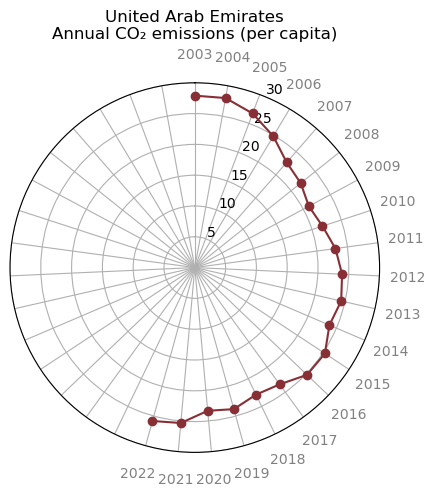

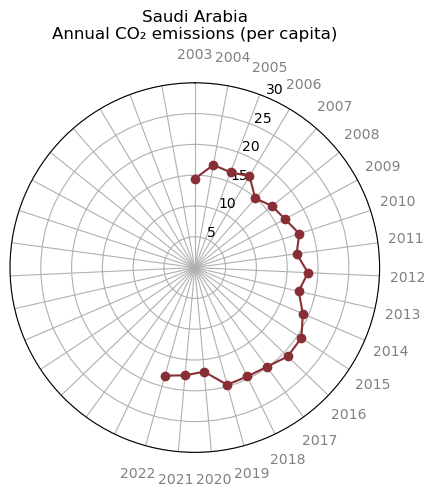

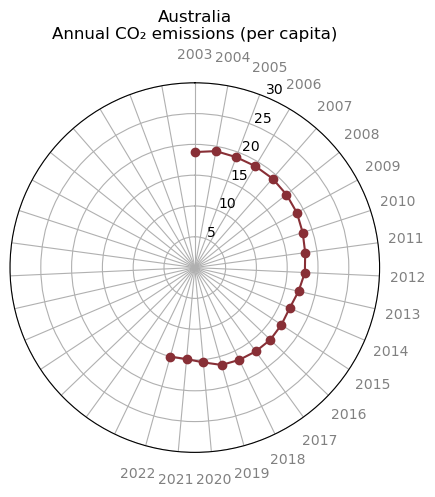

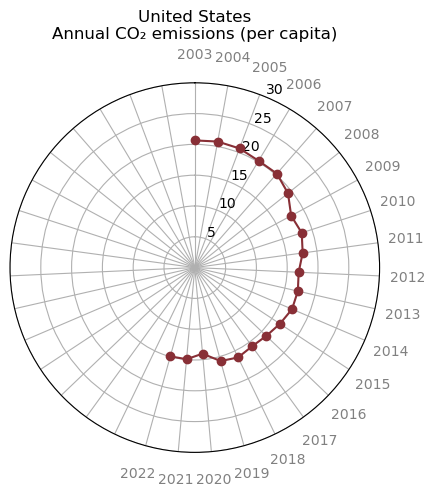

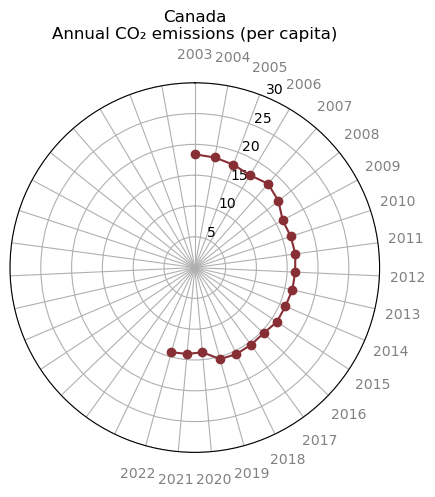

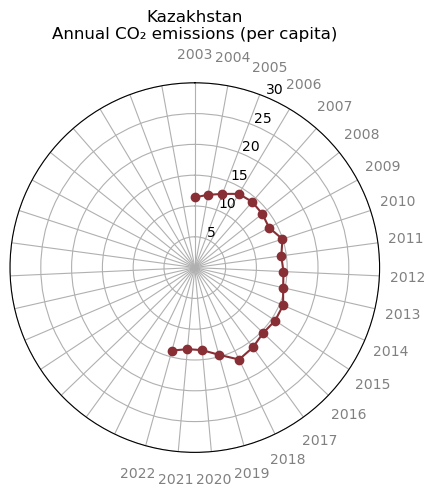

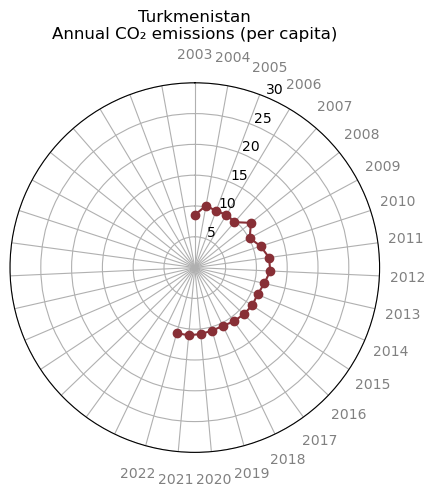

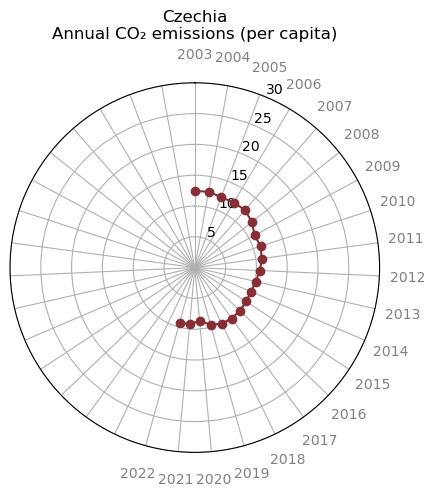

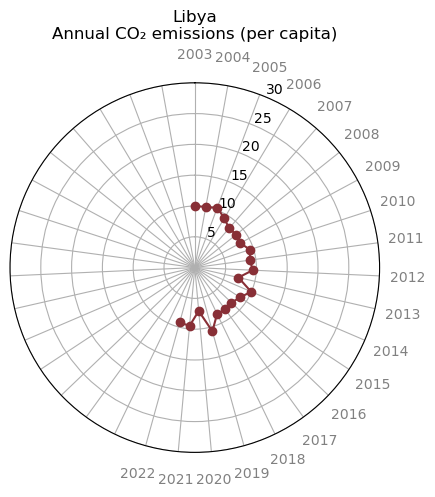

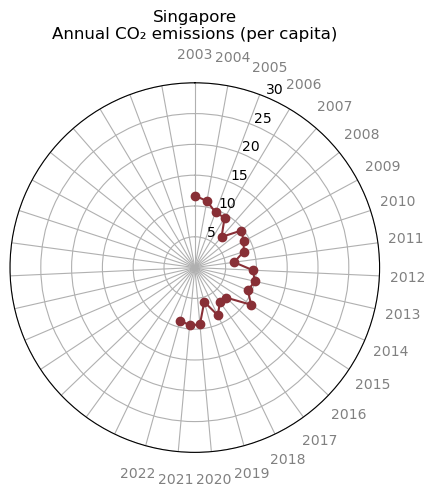

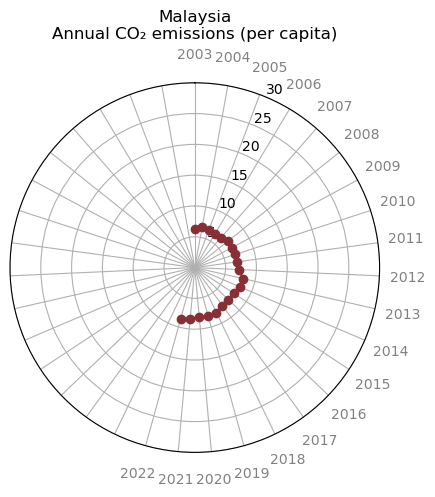

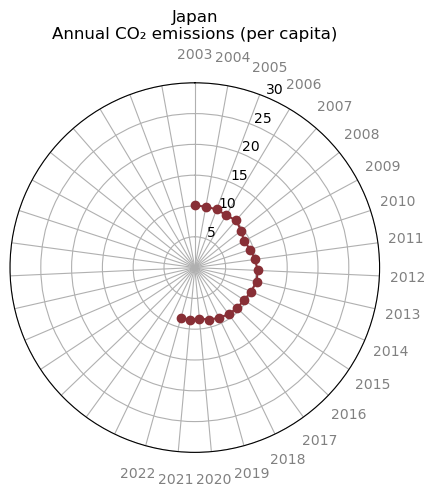

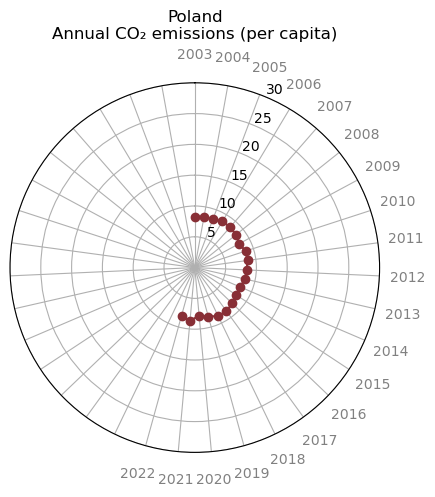

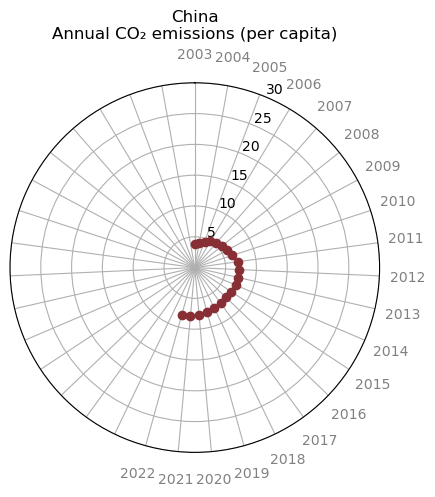

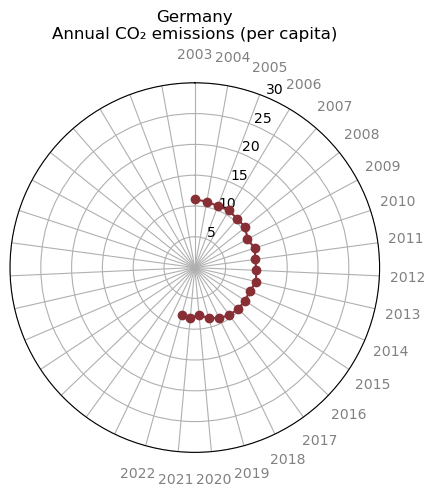

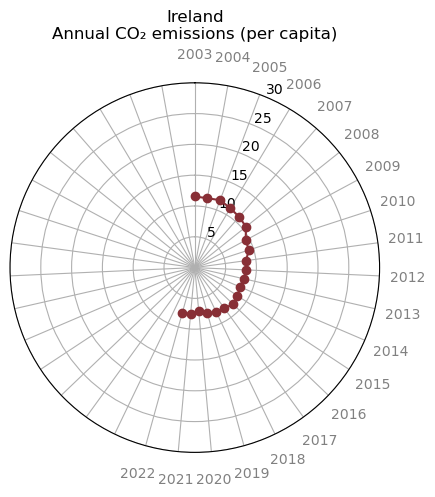

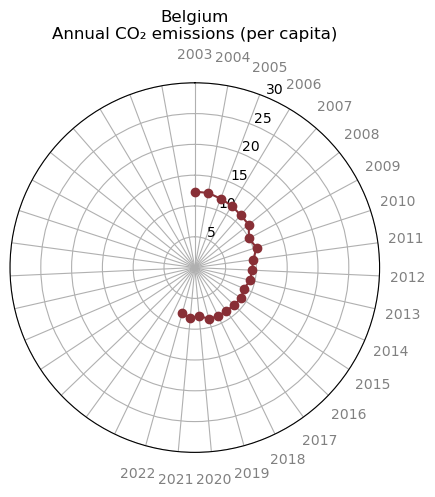

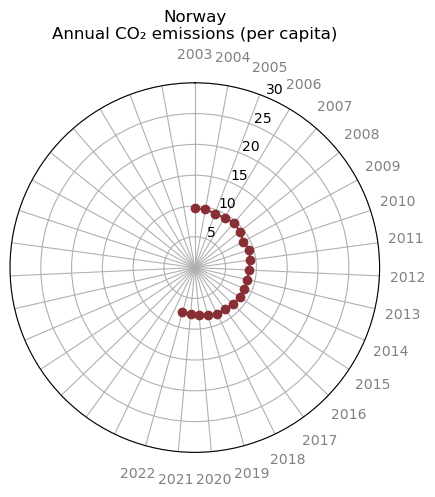

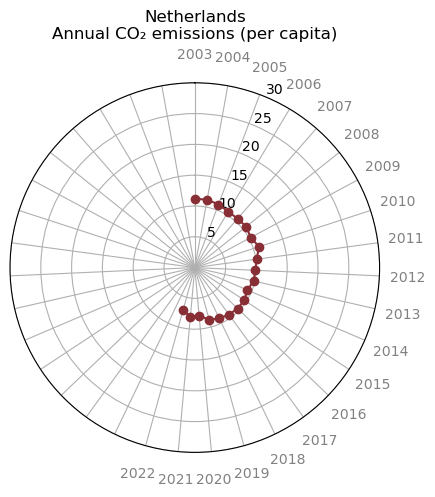

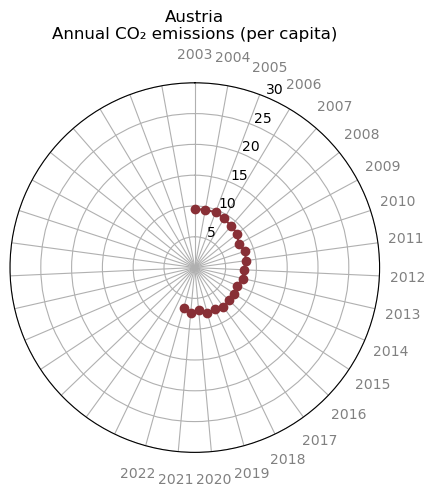

In [143]:
def get_radar_plot(country, path, img_extension, save=False):
    cur_country = c_filter[c_filter['Country']==country]
    # set a consistent scale across all countries
    max_value = 30
    # Initialize the graph and set it as clockwise from the top
    radar_fig = plt.figure()
    radar_ax = radar_fig.add_subplot(111, projection='polar')
    radar_ax.set_theta_direction(-1)
    radar_ax.set_theta_offset(np.pi/2.0)
    plt.ylim(0, max_value)
    # Add padding for future years and scale the angles
    padded_year_length = len(cur_country) + 15
    theta = np.arange(padded_year_length + 1) / float(padded_year_length) * 2 * np.pi
    # Extract values and add padding of null values
    values = cur_country['Annual CO₂ emissions (per capita)'].values
    values = np.pad(values, (0, padded_year_length - len(values) + 1), constant_values=np.nan)
    # Extract labels and add padding of empty strings
    labels = cur_country['Year'].tolist()
    labels += [''] * (padded_year_length - len(labels))
    # Add values and labels to the plot
    l1, = radar_ax.plot(theta, values, color="#882F36", marker="o")
    plt.xticks(theta[:-1], labels, color='grey', size=10)
    radar_ax.tick_params(pad=10)
    radar_ax.set_title(country + "\nAnnual CO₂ emissions (per capita)")
    # Save images if desired
    if save:
        plt.savefig(path + country + img_extension, bbox_inches='tight', transparent=True)
    plt.show()
    

for country in top_twenty_list:
    radar_path = '/Users/lydia/Projects/PerCapitaCO2Emissions_data_visualization/static/radar/'
    get_radar_plot(country, radar_path, '.svg', True) # Set to true to overwrite saved files

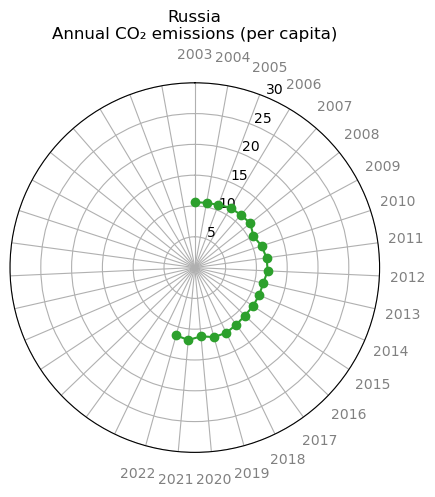

In [119]:
get_radar_plot('Russia', radar_path, '.svg', False)

In [ ]:
print(top_twenty_list)

In [ ]:
radar_United_Arab_Emirates = c_filter[c_filter['Country'] == "United Arab Emirates"]
radar_United_Arab_Emirates = pd.DataFrame(radar_United_Arab_Emirates)
radar_United_Arab_Emirates.head(20)